In [87]:
import LinearAlgebra: I, ⋅
import Base.MathConstants: φ, pi
import Base: cos 
import Statistics: mean
import FiniteDifferences
abstract type DescentMethod end

┌ Info: Precompiling FiniteDifferences [26cc04aa-876d-5657-8c51-4c34ba976000]
└ @ Base loading.jl:1278


# Metody optymalizacji

## Metoda najszybszego spadku z bezwładnością

In [4]:
mutable struct Momentum <: DescentMethod
  α # learning rate
  β # momentum decay
  v # momentum
end

Momentum(α, β, n::Integer) = Momentum(α, β, zeros(n))

function step!(M::Momentum, f, ∇f, x) 
  α, β, v, g = M.α, M.β, M.v, ∇f(x)
    println("Gradient: ", g)
  v[:] = β*v .- α*g
  return x + v
end

step! (generic function with 1 method)

## BFGS

In [14]:
mutable struct BFGS <: DescentMethod
  Q
end
BFGS(n::Integer) = BFGS(Matrix(1.0I, n, n))

function strong_backtracking(f, ∇, x, d; α=1, β=1e-4, σ=0.1)
  y0, g0, y_prev, α_prev = f(x), ∇(x)⋅d, NaN, 0
  αlo, αhi = NaN, NaN
  # bracket phase
  while true
    y = f(x + α*d)
    if y > y0 + β*α*g0 || (!isnan(y_prev) && y ≥ y_prev)
      αlo, αhi = α_prev, α
      break
    end
    g = ∇(x + α*d)⋅d
    if abs(g) ≤ -σ*g0
      return α
    elseif g ≥ 0
      αlo, αhi = α, α_prev
      break
    end
    y_prev, α_prev, α = y, α, 2α
  end
  # zoom phase
  ylo = f(x + αlo*d)
  while true
    α = (αlo + αhi)/2
    y = f(x + α*d)
    if y > y0 + β*α*g0 || y ≥ ylo
      αhi = α
    else
      g = ∇(x + α*d)⋅d
      if abs(g) ≤ -σ*g0
        return α
      elseif g*(αhi - αlo) ≥ 0
        αhi = αlo
      end
      αlo = α
    end
  end
end

function step!(M::BFGS, f, ∇f, x)
  if f(x) ≈ 0.0
    return x
  end

  Q, g = M.Q, ∇f(x)
  α = strong_backtracking(f, ∇f, x, -Q*g)
  x′ = x + α*(-Q*g)
  g′ = ∇f(x′)
  δ = x′ - x
  γ = g′ - g
  Q[:] = Q - (δ*γ'*Q + Q*γ*δ')/(δ'*γ) + (1 + (γ'*Q*γ)/(δ'*γ))[1]*(δ*δ')/(δ'*γ)
  return x′
end

step! (generic function with 3 methods)

## L-BFGS

In [7]:
using LinearAlgebra

mutable struct LBFGS
  m
  δs
  γs
  qs
  LBFGS() = new()
end

function init!(M::LBFGS, m) 
  M.m = m
  M.δs = [] 
  M.γs = [] 
  M.qs = []
  return M
end

function step!(M::LBFGS, f, ∇f, θ) 
    δs, γs, qs = M.δs, M.γs, M.qs 
    m, g = length(δs), ∇f(θ)
    d = -g # kierunek
    if m > 0 
        q = g
        for i in m:-1:1
            qs[i] = copy(q)
            q -= (δs[i]⋅q) / (γs[i]⋅δs[i]) * γs[i]
        end
        z = (γs[m] .* δs[m] .* q) / (γs[m]⋅γs[m]) 
        for i in 1:+1:m
            z += δs[i]*(δs[i]⋅qs[i]-γs[i]⋅z)/(γs[i]⋅δs[i]) 
        end
        d = -z; # rekonstrukcja kierunku
    end
    φ =α-> f(θ+α*d); φ′=α->∇f(θ+α*d)⋅d 
    α = line_search(φ, φ′, d)
    θ′ = θ + α*d; g′ = ∇f(θ′) # nowy wektor
    δ =θ′-θ;γ =g′-g
    push!(δs, δ); push!(γs, γ); push!(qs, zero(θ)) 
    while length(δs) > M.m
        popfirst!(δs); popfirst!(γs); popfirst!(qs) 
    end
    return θ′ 
end

step! (generic function with 3 methods)

In [8]:
function zoom(φ, φ′, αlo, αhi, c1=1e-4, c2=0.1, jmax=1000)
    φ′0 = φ′(0.0) 
    for j=1:jmax
        αj = 0.5(αlo + αhi) # bisection 
        φαj = φ(αj)
        if φαj > φ(0.0) + c1*αj*φ′0 || φαj ≥ φ(αlo)
            αhi = αj 
        else
            φ′αj = φ′(αj)
            if abs(φ′αj) ≤ -c2*φ′0
                return αj
            end
            if φ′αj*(αhi - αlo) ≥ 0.0 
                αhi = αlo
            end
            αlo = αj 
        end
    end
    return 0.5(αlo + αhi) 
end

function line_search(φ, φ′, d, c1=1e-4, c2=0.1, ρ=0.1, αmax=100., jmax=1000)
    αi, αj = 0.0, 1.0
    φαi, φ0, φ′0 = φ(αi), φ(0.0), φ′(0.0) 
    for j=1:jmax
        φαj = φ(αj)
        if φαj > φ0 + c1*αj*φ′0 || (φαj ≥ φαi && j > 1)
            return zoom(φ, φ′, αi, αj)
        end
        φ′αj = φ′(αj)
        if abs(φ′αj) ≤ -c2*φ′0
            return αj 
        end
        if φ′αj ≥ 0.0
            return zoom(φ, φ′, αj, αi)
        end
        αi, αj = αj, ρ*αj + (1.0 - ρ)*αmax
        φαi = φαj 
    end
    return αj 
end

line_search (generic function with 6 methods)

# Test Set up

## Functions

In [9]:
f_beale(x) = (1.5 - x[1] + x[1]*x[2])^2 + (2.25 - x[1] + x[1]*x[2]^2)^2 + (2.625 - x[1] + x[1]*x[2]^3)^2
∇f_beale(x) = [
    2*x[1]*(x[2]^6 + x[2]^4 - 2*x[2]^3 - x[2]^2 - 2*x[2] + 3) + 5.25*x[2]^3 + 4.5*x[2]^2 + 3*x[2] - 12.75, 
    6*x[1]*(x[1]*(x[2]^5 + 0.666667*x[2]^3 - x[2]^2 - 0.333333*x[2] - 0.333333) + 2.625*x[2]^2 + 1.5x[2] + 0.5)
]

f_rosenbrock(x)  = 100*(x[2] - x[1]^2)^2 + (1-x[1])^2
∇f_rosenbrock(x) = [
    400x[1]^3 - 400x[1]*x[2] + 2x[1] - 2,
    200x[2] - 200x[1]^2
]
# a = 20, b = 0.2 and c = 2π.
f_ackley(x, a=20,b=0.2,c = 2 * pi) = -a * exp(-b * sqrt(mean(x.^2))) - exp( mean( cos.(c .* x))) + a + exp(1)
∇f_ackley(x)


x = [3.0, 2.4]

2-element Array{Float64,1}:
 3.0
 2.4

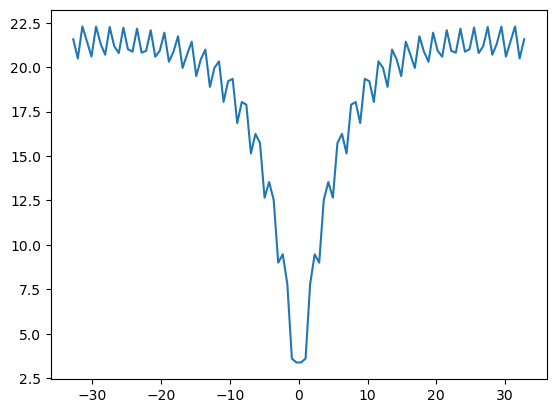

100-element Array{Float64,1}:
  6.983207716308592
 -8.529388974892148
 -0.8537270132620025
  7.511262762108858
 -8.927402498462852
 -0.6336418368535711
  8.000155548248616
 -9.138414620526055
 -0.42486977286409666
  8.4281339606606
 -9.17846145907204
 -0.225052998653572
  8.771002476973646
  ⋮
  0.2250529986536382
  9.17846145907204
 -8.4281339606606
  0.4248697728640289
  9.138414620526055
 -8.000155548248616
  0.6336418368535711
  8.927402498462852
 -7.511262762109023
  0.8537270132620025
  8.529388974892148
 -6.983207716308592

In [93]:
using PyPlot
using Zygote

min = -32.768
max = - 1* min
size = 10^2
x = collect(LinRange(min,max, size))

y = f_ackley.(x)
der = f_ackley'.(x)

PyPlot.plot(x, y)
# PyPlot.plot(x, der)
der

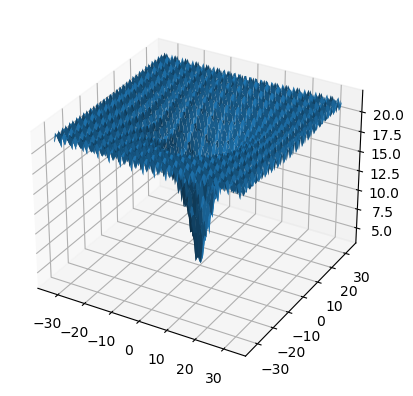

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x000000005A5E2F40>

In [83]:
using PyPlot

test(x,y) = x * y
min = -32.768
max = - 1* min
size = 10^2
x = collect(LinRange(min,max, size))
y = collect(LinRange(min,max, size))

z = zeros(size,size)
for (num_i, i) = enumerate(x)
  for (num_j, j) = enumerate(y)
    z[num_i, num_j] = f_ackley([i j])
    # println("$(num_i);$(num_j)")
  end
end

PyPlot.surf(x, y, z)

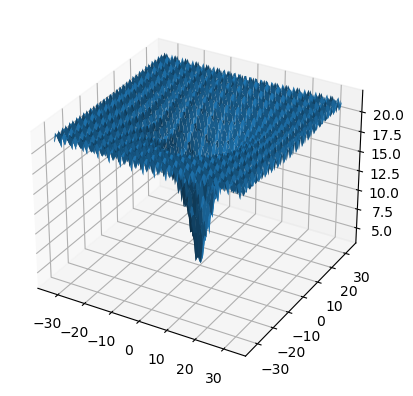

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x000000005A5E2F40>

In [83]:
using PyPlot

min = -32.768
max = - 1* min
size = 10^2
x = collect(LinRange(min,max, size))
y = collect(LinRange(min,max, size))

z = zeros(size,size)
for (num_i, i) = enumerate(x)
  for (num_j, j) = enumerate(y)
    z[num_i, num_j] = f_ackley([i j])
    # println("$(num_i);$(num_j)")
  end
end

PyPlot.surf(x, y, z)

# Test

In [11]:
function optimalize(f, ∇f, x₀, opt, e, i)
    pts = [x₀] # kolejne wektory x
    err = Float64[] # kolejne wartości f. straty
    p = 0
    while true
        println("Iteracja p=", p)
        println("Wektor x: ", pts[end])
        push!(err, f(pts[end])) # odłóż wynik funkcji dla najnowszego wektora x (miara błędu)
        println("Error: ", err[end])
        println()
        if f(pts[end]) < e || p > i
            break
        end
        push!(pts, step!(opt, f, ∇f, pts[end]))
        p += 1
    end
    
    pts, err, p
end

optimalize (generic function with 1 method)

In [15]:
bfgs = BFGS(2)

pts, err, i = optimalize(f_rosenbrock, ∇f_rosenbrock, x, bfgs, 0.0001, 100)
println("Ilość iteracji: ", i)
println("Wektor x wynikowy: ", pts[end])
println("Błąd: ", err[end])

Iteracja p=0
Wektor x: [0 0]
Error: 1.0



LoadError: [91mDimensionMismatch("dimensions must match: a has dims (Base.OneTo(1), Base.OneTo(2)), b has dims (Base.OneTo(2),), mismatch at 1")[39m

In [16]:
lbfgs = LBFGS(); init!(lbfgs, 7)

pts, err, i = optimalize(f_rosenbrock, ∇f_rosenbrock, x, lbfgs, 0.0001, 100)
println("Ilość iteracji: ", i)
println("Wektor x wynikowy: ", pts[end])
println("Błąd: ", err[end])

Iteracja p=0
Wektor x: [0 0]
Error: 1.0



LoadError: [91mDimensionMismatch("dimensions must match: a has dims (Base.OneTo(1), Base.OneTo(2)), b has dims (Base.OneTo(2),), mismatch at 1")[39m

In [17]:
# weird stuff happens here
momentum = Momentum(0.00000000000001, 0.01, 2)

pts, err, i = optimalize(f_rosenbrock, ∇f_rosenbrock, x, momentum, 0.01, 100)
println("Ilość iteracji: ", i)
println("Wektor x wynikowy: ", pts[end])
println("Błąd: ", err[end])

Iteracja p=0
Wektor x: [0 0]
Error: 1.0

Gradient: [-2, 0]


LoadError: [91mDimensionMismatch("dimensions must match: a has dims (Base.OneTo(1), Base.OneTo(2)), b has dims (Base.OneTo(2),), mismatch at 1")[39m